# Networks Exercise

## Table of Contents

- [Introduction](#Introduction)
- [Setup](#Setup)

    - [Connecting to the Neo4j Database](#Connecting-to-the-Neo4j-Database)
    - [Testing our connection](#Testing-our-connection)
    
- [Brief Overview of Neo4j and Cypher](#Brief-Overview-of-Neo4j-and-Cypher)

    - [How Neo4j Works](#How-Neo4j-Works)
    - [Components of a Simple Cypher Query](#Components-of-a-Simple-Cypher-Query)
    
- [Part 1 - Cypher Query Language](#Part-1---Cypher-Query-Language)

    - [Exercise - Querying Employee Nodes](#Exercise---Querying-Employee-Nodes)
    - [Exercise - The WORKED_WITH relationship](#Exercise---the-WORKED_WITH-relationship)
    
- [Part 2 - Neo4j and `networkx`](#Part-2---Neo4j-and-networkx)

    - [Importing data from Neo4j into `networkx`](#Importing-data-from-Neo4j-into-networkx)
    - [Visualizing a Graph in `networkx`](#Visualizing-a-Graph-in-networkx)
    - [Creating and Plotting a Subgraph](#Creating-and-Plotting-a-Subgraph)
    
        - [Exercise - Subsetting a Graph](#Exercise---Subsetting-a-Graph)
        
- [Part 3 - Analyzing Networks](#Part-3---Analyzing-Networks)

    - [Network Measures](#Network-Measures)
    - [Exercise - Calculating Network Metrics](#Exercise---Calculating-Network-Metrics)
    - [Exercise - Analyzing a Sub Graph](#Exercise---Analyzing-a-Sub-Graph)
    - [Plotting Network Metrics](#Plotting-Network-Metrics)
    - [Exercise - degree vs. betweeness centrality](#Exercise---degree-vs.-betweeness-centrality)
    
- [Part 4 - Analyzing Graphs](#Part-4---Analysing-Graphs)

    - [Exercise - function that plots centrality metrics](#Exercise---function-that-plots-centrality-metrics)

## Introduction

- back to [Table of Contents](#Table-of-Contents)

This exercise will go over the basics on how to connect to a neo4j database, query the database, and analyse data.  It is broken up into two Jupyter IPython notebooks:

- This file, `networks_exercise.ipynb`, contains an exercise you can run through to practice working with Neo4j and `networkx`.
- The file `networks_with_neo4j.ipynb`, is the first notebook you should run.  It contains an overview of Neo4j and its Cypher query language, how you interact with Neo4j using Python, and how you analyze networks using the Python `networkx` package.

Before you begin this lesson:

* Read through and make sure you've followed all the steps in the file README.md inside this exercise's folder.
* Read though the "Installing neo4j" Guide (either the PDF or the Word Document).
* Start your neo4j server using the "Ne04j Community Edition" application on your computer (you can confirm it is running by opening [http://localhost:7474/](http://localhost:7474/) - if neo4j is running, you'll either get the "$" prompt or be asked to log in.  If neo4j is not running, you'll get an error message indicating the page cannot load).
* Work through the `networks_with_neo4j.ipynb` Jupyter IPython notebook, making sure to run all the code cells so you know your software environment is set up and working.

## Setup

- back to [Table of Contents](#Table-of-Contents)

First, we'll import python packages needed for the code in this notebook.  If you stop in the middle of this notebook, close it, then come back later to continue, make sure to run these imports each time you start up the notebook again.

In [14]:
# Imports 
import sys

# import six for python 2 and 3 support.
import six

# py2neo - Python package for interacting with neo4j.
import py2neo

import networkx
import numpy
import operator 
import pandas
import pprint
import pymysql

# Allows plots to be showed inline 
import matplotlib
%matplotlib inline

import datetime
print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

--COMPLETE-- at 2017-05-08 11:27:17.682727


### Connecting to the Neo4j Database 

- back to [Table of Contents](#Table-of-Contents)

To connect to the Neo4j Database we will be using the `py2neo` Python package ( [http://py2neo.org](http://py2neo.org) ).

In the cell below we will begin by using `py2neo` to create a connection to our neo4j database. 

In [15]:
# Set up connection to Neo4j local Database 
# You will need to authenticate your connection, use the next line as an example 
# authenticate("localhost:7474", "<YOUR USENAME HERE>, Default is: neo4j", "<YOUR_PASSWORD_HERE>")

# set up authentication parameters
database_host = "localhost"
database_port = "7474"
database_username = "neo4j"
database_password = "password"

# authenticate with "py2neo.authenticate()" function.
py2neo.authenticate( database_host + ":" + database_port, database_username, database_password )

# Create a variable for our graph and print our connection infomation
graph_db = py2neo.Graph()
print( "Connection to Neo4j at " + str( graph_db ) + " created at " + str( datetime.datetime.now() ) )

Connection to Neo4j at <Graph uri=u'http://localhost:7474/db/data/'> created at 2017-05-08 11:27:20.079080


### Testing our connection

- back to [Table of Contents](#Table-of-Contents)

To extract data from our database, we will pass cypher commands Neo4j using the `data()` method on an instance of py2neo's Graph object (more details on this follow).

More details on this follow.  First, however, to test our connection, we'll use the `data()` method to run a basic cypher query that asks Neo4j to find all nodes:

    MATCH (n)

but return only one:

    RETURN n limit 1;

In [16]:
# The syntax below translates to,
#'Match (Find) any node, lets call it "node", and show me its data. Limit the results to 1'

graph_db.data( "MATCH ( node ) RETURN node limit 1;" )

[{u'node': (fa07e28:Employee {employeeid:"90014540",position:"FACULTY"})}]

## Brief Overview of Neo4j and Cypher

- back to [Table of Contents](#Table-of-Contents)

### How Neo4j Works

- back to [Table of Contents](#Table-of-Contents)

When you think of data, you probably imagine an excel table where each row is an individual observation or data point. 

For example:

|name | age | employee_id|
|-----|-----|------------|
|Joe  |  34 |   12345    |
|Ann  |  54 |   12346    |
    
In Neo4j, each of these rows is stored as and referred to as a Node.  Neo4j nodes can contain all the same information as a tabular representation of data like a spreadsheet or a traditional database table, but they are structured a little differently.

A traditional database table will have a set number of columns, and each row in the table will have the same set of columns.  Different types of data are stored in different tables, and rows within a given table can not have different sets of values.

In Neo4j (and in other "NoSQL" databases that use a record model rather than a relational table model), all things in the system are placed in a single "Node" database, and each can have any properties you want to assign to them.

So, where a relational database might have separate tables for students and employees, for example, in Neo4j, students and employees are both stored as nodes, and the properties of the node are set as is appropriate for the type of node (so employees have name, age, and an employee ID - just like in the example table above - and students might have name, age, major, expected graduation date, and student ID).

You can (and should!) have types of nodes that all are expected to have the same set of properties, but Neo4j and other NoSQL databases do not formally require this like a relational database does when you place data into a table.

For example, when you run the following query using py2neo:

    MATCH ( n ) RETURN n LIMIT 1;
    
You get back the following:

    [{'n': (b63c693:Employee {employeeid:"90014540",position:"FACULTY"})}]
    
OR, formatted more politely:

    [
        {
            'n': (
                b63c693 : Employee {
                    employeeid:"90014540",
                    position:"FACULTY"
                }
            )
            
        }
    ]
    
This structure uses Python (and JSON) conventions for lists and dictionaries to tell you that it returns:

- a list ( the outer "[]" )
- of dictionaries ( the "{}" inside the list )
- each entry of which contains a mapping of one of the sets of nodes you've requested in RETURN (in this case, 'n')
- to a static list (inside the parentheses - "()") of the matching nodes that maps IDs (example: `b63c693`) to node properties (`Employee {employeeid:"90014540",position:"FACULTY"}`).

The information about an employee is still there (well, other than the name since we've removed it from our data set...), but instead of storing each peice of information on an employee in a pre-defined column, each employee's information is stored as **properties** on a node, and the type of node is captured as a **label**, *Employee*, associated with the node that identify it as being of type "Employee".

### Components of a Simple Cypher Query

- back to [Table of Contents](#Table-of-Contents)

Neo4j uses the Cypher Query Language to get information out of the Database.  The basic syntax is "`MATCH ( n ) RETURN n LIMIT 1;`":

+ MATCH ( n )

    - The `MATCH` clause is essentially the same as the SELECT clause in SQL.  It tells the Cypher query that you are filtering, and the information in parentheses defines where the query will be looking.
    - `( n )` tells the Cypher Query to filter and retrieve matches from all nodes.  In `MATCH`, the letter you place here is a name you'll use in subsequent parts of the query to refer to matching nodes (like the `AS` keyword in SQL).  It can be any name, does not need to be `n`.
    - Simply placing a name here means it will look at all nodes, regardless of type/label.  To filter on a label, append the label after the name, separated by a colon.  So, for nodes of type "Employee", your `MATCH` would look something like: `MATCH ( employees : Employee )`
    - You can place more than one type of node inside the parentheses of a `MATCH` clause.

+ RETURN n

    - The `RETURN` clause tells the Cypher query what information should be returned for matching nodes.
    - If you just return the name of the node specified in `MATCH ()`, then it will return all properties for each node.
    - You can also specify the names of specific properties of nodes ( "`RETURN n.employeeid, n.position`", for example).
    - A `RETURN` clause is needed in every query.

+ LIMIT 1     

    - LIMIT lets you request a subset of all matches be returned (in this case, just 1).  This does not imply order, so you might get a different node each time you run this query.
    - This is similar to the LIMIT clause in an SQL statement.
    
+ all Cypher queries end with a semi-colon ( ";" ).

The following query will return 20 nodes from the database:  

    graph_db.data( "MATCH ( node ) RETURN node LIMIT 20;" )

If I wanted to query just nodes of type "Award" (where types are signified by labels associated with nodes), I would add a filter for the label "Award" inside the MATCH clause ( `MATCH ( n : Award )` ):  

    graph_db.data( "MATCH ( awards : Award ) RETURN awards LIMIT 20;" )

In [17]:
# You can use this cell to Test the Cypher Queries.  For example, let's try to:
# - Match (Find) any nodes that are of type Award
# - and show the award number (award_num) for each of the nodes returned,
# - limiting the number of results to 20.

graph_db.data( "MATCH ( awards : Award ) RETURN awards.award_num LIMIT 20;" )

[{u'awards.award_num': u'aw1000'},
 {u'awards.award_num': u'aw1001'},
 {u'awards.award_num': u'aw1002'},
 {u'awards.award_num': u'aw1003'},
 {u'awards.award_num': u'aw1004'},
 {u'awards.award_num': u'aw1005'},
 {u'awards.award_num': u'aw1006'},
 {u'awards.award_num': u'aw1007'},
 {u'awards.award_num': u'aw1008'},
 {u'awards.award_num': u'aw1009'},
 {u'awards.award_num': u'aw1010'},
 {u'awards.award_num': u'aw1011'},
 {u'awards.award_num': u'aw1012'},
 {u'awards.award_num': u'aw1013'},
 {u'awards.award_num': u'aw1014'},
 {u'awards.award_num': u'aw1015'},
 {u'awards.award_num': u'aw1016'},
 {u'awards.award_num': u'aw1017'},
 {u'awards.award_num': u'aw1018'},
 {u'awards.award_num': u'aw1019'}]

## Cypher Query Language

- back to [Table of Contents](#Table-of-Contents)

### Exercise - Querying Employee Nodes

- back to [Table of Contents](#Table-of-Contents)

For our first exercise, write a Cypher query that:

- matches nodes of type Employee and returns the employeeid.
- Limits the results to 10 nodes.

Run the query using your py2neo Graph object's `data()` method and output the results.

In [18]:
graph_db.data( "MATCH ( employees : Employee ) RETURN employees.employeeid LIMIT 10;" )

[{u'employees.employeeid': u'90014540'},
 {u'employees.employeeid': u'90026679'},
 {u'employees.employeeid': u'90017693'},
 {u'employees.employeeid': u'90028696'},
 {u'employees.employeeid': u'90013819'},
 {u'employees.employeeid': u'90001118'},
 {u'employees.employeeid': u'90001300'},
 {u'employees.employeeid': u'90023086'},
 {u'employees.employeeid': u'90017074'},
 {u'employees.employeeid': u'90025003'}]

Your query should return a list containing dictonaries.

Example returned Object from py2neo:

    [{u'employees.employeeid': u'90014540'},
     {u'employees.employeeid': u'90026679'},
     {u'employees.employeeid': u'90017693'},
     {u'employees.employeeid': u'90028696'},
     {u'employees.employeeid': u'90013819'},
     {u'employees.employeeid': u'90001118'},
     {u'employees.employeeid': u'90001300'},
     {u'employees.employeeid': u'90023086'},
     {u'employees.employeeid': u'90017074'},
     {u'employees.employeeid': u'90025003'}]

What makes graph databases like Neo4j special is the ability to create relationships between nodes.

For instance, the database we created in the first notebook for this exercise has two types of relationships: WORKED_ON and WORKED_WITH

+ Employees have a *WORKED_ON* relationship with nodes which represent awards on which the person has worked.   
+ Employees have a *WORKED_WITH* relationship other persons that have worked on the same award.   

To view what this looks like, this query will return 5 instances of the pattern where an employee worked_on an award, and return the relationship.

In [19]:
# create query string

# MATCH clause
query_string = "MATCH ( employee : Employee )"
query_string += " - [ worked_on : WORKED_ON ] ->"
query_string += " ( award : Award )"

# RETURN clause
query_string += " RETURN worked_on"

# LIMIT clause
query_string += " LIMIT 5;"

# run the query
graph_db.data( query_string )

[{u'worked_on': (fa07e28)-[:WORKED_ON]->(db59113)},
 {u'worked_on': (d7f3228)-[:WORKED_ON]->(ba2d86a)},
 {u'worked_on': (c89b42f)-[:WORKED_ON]->(ee9f6b6)},
 {u'worked_on': (b4137fe)-[:WORKED_ON]->(b0a9d61)},
 {u'worked_on': (a9f706b)-[:WORKED_ON]->(cd2ade1)}]

### Exercise - the WORKED_WITH relationship

- back to [Table of Contents](#Table-of-Contents)

Write a query that:

- matches nodes of type Employee that have a WORKED_WITH relationship with another node of type Employee.
- Returns the employeeid of both employee nodes.
- Limits the response to 5.

In [20]:
# create query string

# MATCH clause
query_string = "MATCH ( employee1 : Employee )"
query_string += " - [ worked_with : WORKED_WITH ] ->"
query_string += " ( employee2 : Employee )"

# RETURN clause
query_string += " RETURN employee1.employeeid, employee2.employeeid"

# LIMIT clause
query_string += " LIMIT 5;"

# run the query
graph_db.data( query_string )

[{u'employee1.employeeid': u'90029620', u'employee2.employeeid': u'90023086'},
 {u'employee1.employeeid': u'90026012', u'employee2.employeeid': u'90017074'},
 {u'employee1.employeeid': u'90021622', u'employee2.employeeid': u'90025003'},
 {u'employee1.employeeid': u'90023237', u'employee2.employeeid': u'90000321'},
 {u'employee1.employeeid': u'90010462', u'employee2.employeeid': u'90001779'}]

Your query should return a list containing dictonaries.

    [{u'employee1.employeeid': u'90000919', u'employee2.employeeid': u'90028696'},
     {u'employee1.employeeid': u'90024693', u'employee2.employeeid': u'90013819'},
     {u'employee1.employeeid': u'90001652', u'employee2.employeeid': u'90001118'},
     {u'employee1.employeeid': u'90025754', u'employee2.employeeid': u'90001300'},
     {u'employee1.employeeid': u'90004472', u'employee2.employeeid': u'90023086'}]

## Part 2 - Neo4j and `networkx `

- back to [Table of Contents](#Table-of-Contents)

Understanding this network would be much easier if we could render charts of it, so we could see the relationships.

To do this, we first have to convert our Neo4j data into `networkx` objects.  We can do this using the data that results from one of our Cypher queries.

### Importing data from Neo4j into `networkx `

- back to [Table of Contents](#Table-of-Contents)

First create a query to pull in all of the relations in the system (so not including isolates?).

In [39]:
# declare variables - get all relations
query_string = ""
all_graph_data = ""

# Get ALL the Nodes and relationships 
# MATCH clause
query_string = "MATCH ( node1 { employeeid: '90024517' } )"
query_string += " - [ any_relation ] ->"
query_string += " ( node2 )"

# RETURN clause
query_string += " RETURN node1, any_relation, node2"

# LIMIT clause
#query_string += " LIMIT 5"

# And, the closing semi-colon
query_string += ";"

# run the query
all_graph_relations = graph_db.data( query_string )

pprint.pprint( all_graph_relations )

print( "Relations query --COMPLETE-- at " + str( datetime.datetime.now() ) )

[{u'any_relation': (a21743e)-[:WORKED_ON]->(f6b7edd),
  u'node1': (a21743e:Employee {employeeid:"90024517",position:"FACULTY"}),
  u'node2': (f6b7edd:Award {award_num:"aw1257"})},
 {u'any_relation': (a21743e)-[:WORKED_ON]->(a43fe2c),
  u'node1': (a21743e:Employee {employeeid:"90024517",position:"FACULTY"}),
  u'node2': (a43fe2c:Award {award_num:"aw1468"})}]
Relations query --COMPLETE-- at 2017-05-08 11:41:05.351898


Next, we'll use the results of this query to make a list of all the employees, students, and awards in our data set.

In [38]:
# The following code is used to keep track of employees vs. students vs. award numbers,

# declare variables - make lists of types of nodes.
employees = {}
awards = {} 
students = {}
label_set = set()
relation_spec = None
node_1 = None
node_2 = None
relation = None
node_neo4j_id = None
node_properties_dict = None
node_position = ""
node_employeeid = ""
node_award_num = ""
is_employee = False
is_student = False
is_award = False
employee_id_set = set()
student_id_set = set()
award_id_set = set()
employee_count = 0
student_count = 0
award_count = 0
node_counter = 0
test_counter = 0

# Loop over all the relations returned by our query.
relation_counter = 0
for relation_spec in all_graph_relations:

    # increment node_counter
    node_counter += 1

    # initialize
    is_employee = False
    is_student = False
    is_award = False
    test_counter = 0
    
    # get the node1 py2neo Node object for the current relation.
    relation = relation_spec[ "any_relation" ]
    node_1 = relation_spec[ "node1" ]
    node_2 = relation_spec[ "node2" ]
    
    # get node 1's ID and properties
    node_1_neo4j_id = node_1.__name__
    node_1_properties_dict = dict( node_1 )
    
    '''
    # Play with the py2neo.Node object.
    print( "======================================" )
    print( "Current Node ( #" + str( node_counter ) + " ) as string: " + str( node_1 ) )
    print( "- type() of Node: " + str( type( node_1 ) ) )
    print( "- list of labels: " + str( node_1.labels() ) )
    print( "- ID of node: " + str( node_1.__name__ ) )
    print( "- full UUID: " + str( node_1.__uuid__ ) )
    
    # print out all of the node Object's properties
    print( "- all Node properties:" )
    for property, value in six.iteritems( vars( node_1 ) ):
        print( str( property ) + " : " + str( value ) )
    '''

    
    # build list of labels - loop over labels for this node.
    node_1_labels = node_1.labels()
    for label in node_1_labels:
        
        # add label to label set.
        label_set.add( label )
        
    #-- END loop over labels --#
    
    # what type of node?
    is_employee = node_1.has_label( "Employee" )
    is_student = node_1.has_label( "Student" )
    is_award = node_1.has_label( "Award" )
    if ( ( is_employee == True ) or ( is_student == True ) ):
        
        # get person information
        node_1_position = node_1_properties_dict.get( "position", None )
        node_1_employeeid = node_1_properties_dict.get( "employeeid", None )
        
        # employee?
        if ( is_employee == True ):
            
            # employee.  Add to dictionary and set.
            employee_count += 1
            employee_id_set.add( node_1_employeeid )
            employees[ node_1_employeeid ] = node_1_neo4j_id
            
            # is position other than FACULTY?
            if ( node_1_position != "FACULTY" ):
                
                # not Employee, but not FACULTY - error?
                print( "ERROR? - Employee's position is \"" + str( node_1_position ) + "\", not \"FACULTY\"" )
                
            #-- END check to see if position matches node type --#
            
            test_counter += 1
            
        #-- END check to see if Employee --#
        
        # student?
        if ( is_student == True ):
            
            # student.  Add to dictionary and set.
            student_count += 1
            student_id_set.add( node_1_employeeid )
            students[ node_1_employeeid ] = node_1_neo4j_id
            
            # is position FACULTY?
            if ( node_1_position == "FACULTY" ):
                
                # not Employee, but FACULTY - error?
                print( "ERROR? - Student's position is \"" + str( node_1_position ) + "\", should be \"STUDENT\"" )
                
            #-- END check to see if position matches node type --#
            
            test_counter += 1
            
        #-- END check to see if Student --#
        
    elif ( is_award == True ):
        
        # get award information
        node_1_award_num = node_1_properties_dict.get( "award_num", None )
            
        # award.  Add to dictionary and set.
        award_count += 1
        award_id_set.add( node_1_award_num )
        awards[ node_1_award_num ] = node_1_neo4j_id
        
    #-- END check to see what type --#
    
    if ( test_counter > 1 ):
        
        print( "TEST COUNTER > 1: " + str( node_1 ) )
        
#-- END loop over all relations --#

print( "label set = " + str( label_set ) )
print( "====> Employees - unique = " + str( len( employee_id_set ) ) + "; total nodes = " + str( employee_count ) )
print( "====> Students  - unique = " + str( len( student_id_set ) ) + "; total nodes = " + str( student_count ) )
print( "====> Awards    - unique = " + str( len( award_id_set ) ) + "; total nodes = " + str( award_count ) )

print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

label set = set([u'Employee'])
====> Employees - unique = 1; total nodes = 2
====> Students  - unique = 0; total nodes = 0
====> Awards    - unique = 0; total nodes = 0
--COMPLETE-- at 2017-05-08 11:40:41.655555


Finally, we'll convert the overall data structure that was returned by our query into a `pandas` DataFrame and import the data into `networkx` from that DataFrame.

In [23]:
# declare variables
all_relations_df = None
all_relations_nx = None # networkx (nx) representation of graph

# Convert all_data to a dataframe object
all_relations_df = pandas.DataFrame( all_graph_relations )

#print( all_relations_df )

# Adding a 'weight' column to see connections better
all_relations_df[ 'weight' ] = .01

# Use the networkx.from_pandas_dataframe() method to create
#     a networkx graph of all the data.
#     More info: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html#from-pandas-dataframe
all_relations_nx = networkx.from_pandas_dataframe( all_relations_df, 'node1', 'node2', ['weight'] )

print( "networkx import --COMPLETE-- at " + str( datetime.datetime.now() ) )

networkx import --COMPLETE-- at 2017-05-08 11:28:07.142898


### Visualizing a Graph in `networkx`

- back to [Table of Contents](#Table-of-Contents)

Now we will use the `networkx.draw()` function to draw the graph of the network we've created.  First, we will create a function that accepts a list of nodes and creates an associated list of color values for each node.

In [24]:
def calculate_color_values_for_nodes( node_list_IN ):

    # return reference
    color_values_OUT = []
    
    # declare variables
    color_values = []
    node_counter = -1
    node = None
    py2neo_node = None
    node_properties_dict = None
    node_id = -1
    node_type = ""
    color_value = ""
    
    # loop over nodes
    node_counter = 0
    for node in node_list_IN:

        '''
        # Play with the networkx.Node object.
        print( "======================================" )
        print( "Current Node ( #" + str( node_counter ) + " ) as string: " + str( node ) )
        print( "- type() of Node: " + str( type( node ) ) )

        # print out all of the node Object's properties
        print( "- all Node properties:" )
        for item in node:
            print( str( item ) )
        '''

        # initialize variables
        node_id = 0
        node_type = None

        # get the node's properties (still a reference to py2neo.types.Node)
        py2neo_node = node[ 0 ]
        node_properties_dict = dict( py2neo_node )

        #print( "node[ 0 ] type = " + str( type( py2neo_node ) ) )

        # Is there an employee ID?
        if "employeeid" in node_properties_dict:

            # yes - store it as ID, and also get position.
            node_id = node_properties_dict.get( "employeeid", None )
            node_type = node_properties_dict.get( "position", None )

        else:

            # no employee ID, so award.
            node_id = node_properties_dict.get( "award_num", None )
            node_type = "AWARD"

        #-- END check to see if employee ID. --#

        # What type?
        if node_type == "FACULTY":

            # FACULTY = green
            color_value = 'g'  # green

        elif node_type == "STUDENT":

            # STUDENT = yellow
            color_value = 'y'  # yellow

        else:

            # other = AWARD = red
            color_value = 'r'  # red

        #-- END check to see what type based on position --#

        color_values.append( color_value )

    #-- END loop over nodes to derive node colors --#
    
    # place color values list in return reference.
    color_values_OUT = color_values
    
    return color_values_OUT
    
#-- END function calculate_color_values_for_nodes() --#

print( "def calculate_color_values_for_nodes() --COMPLETE-- at " + str( datetime.datetime.now() ) )

def calculate_color_values_for_nodes() --COMPLETE-- at 2017-05-08 11:28:22.321451


network graphing --COMPLETE-- at 2017-05-08 11:28:26.809523


/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


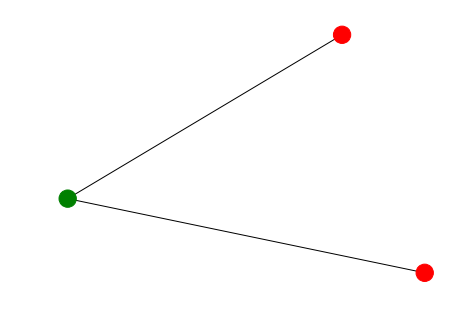

In [25]:
# visualize the network       

# declare variables
all_relations_nodes = None
color_values = []

# use networkx graph.nodes() method to retrieve just list of nodes
all_relations_nodes = all_relations_nx.nodes( data = True )

# get colors of nodes.
color_values = calculate_color_values_for_nodes( all_relations_nodes )
        
# output_graph
networkx.draw( all_relations_nx, node_color = color_values )

print( "network graphing --COMPLETE-- at " + str( datetime.datetime.now() ) )

Admittently, this is not the most informative graph.  There are too many nodes and connections to be able to see any patterners or insigths in the dataset. At best, you might be able to get a rough idea of the relative proportions of employee, award and student nodes (which is not in itself particularly useful since the ties are of different types).

### Creating and Plotting a Subgraph

- back to [Table of Contents](#Table-of-Contents)

We just created a plot of all the Employees, Students, and Awards that are a part of any relationship in our graph database.  Now let's practice plotting subgraphs.

To start, here is an example of a Cypher query to filter nodes based on values of properties within the node.  This query retrieves the Node for a particular employee of interest, that with the employeeid of "90022882".

In [26]:
# This is the employee id of an employee I would like to search for. It is saved into a variable, employee_id_parameter 
employee_id_parameter = '90022882'

# This Cypher query searches for an employee where the employee id is provided by the parameter, employee_id_parameter 
# This query translates to,
# Find the Node of type Employee where the employee id is equal to the value in the
# variable employee_id_parameter. Return that nodes data.

query_string = "MATCH (e:Employee {employeeid: '"
query_string += employee_id_parameter
query_string += "'}) RETURN e;"

graph_db.data( query_string ) 

[{u'e': (d834d96:Employee {employeeid:"90022882",position:"FACULTY"})}]

#### Exercise - Subsetting a Graph

- back to [Table of Contents](#Table-of-Contents)

Write a function that:

- accepts a specific award number.
- finds all the Employees/Students who worked on that award.
- plots the graph.
- returns this subgraph as a networkx graph object instance.

**_Hints_**:
- The folowing Cypher query returns the employees and student who worked on the award 'aw1006'

        MATCH (n) -[r:WORKED_ON] -> (a:Award {award_num:'aw1006'}) RETURN n,r

- see example above for how to include a variable value in a Cypher Query string.

  award_award_num person_node_employeeid person_node_position
0          aw1501               90028906              FACULTY


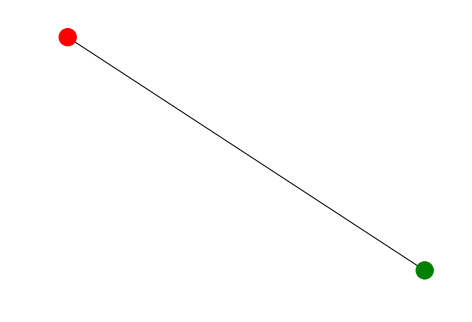

In [27]:
def employee_peers(award_num):
    
    """
    Creates a networkx plot of employees and students that have worked on an award.
    
    Parameters
    ----------
    award_num - The award_num of a specifc award, ie aw1006
    
    Returns 
    --------
    A Networkx graph object of an award and the persons who worked on that award 
    
    """
    
    # declare variables
    award = None
    query_string = ""
    query_result = None
    worked_on_data_df = None
    worked_on_columns = None
    employees = None
    awards = None
    node = None
    
    # Collect Employees that worked on the requested award. 
 
    award = award_num
    # This Cypher Query translates to,
    # Fins the nodes that have a WORKED_ON relationship with an node of type Award that has the award_num of the value of the 
    # award variable. Return the employeeid and award number of the found nodes 
    
    # build query string to get all nodes that worked on a particular award
    query_string = "MATCH ( person_node )"
    query_string += " - [ relation : WORKED_ON ] ->"
    query_string += " ( award : Award { award_num: '"
    query_string += award
    query_string += "'})"
    query_string += " RETURN person_node.employeeid, person_node.position, award.award_num"
    #query_string += " LIMIT 5"
    query_string += ";"
    
    # run query
    query_result = graph_db.data( query_string ) 
    
    # Convert to DataFrame
    worked_on_data_df = pandas.DataFrame( query_result )
    
    # get columns
    worked_on_columns = worked_on_data_df.columns

    # break this out - replace periods with underscores in column names
    worked_on_columns = worked_on_columns.map(lambda x: x.replace('.', '_') if isinstance( x, six.string_types ) else x)

    # place updated columns back in the DataFrame.
    worked_on_data_df.columns = worked_on_columns
    
    pprint.pprint( worked_on_data_df )

    # Create the Networkx Graph 
    worked_on_graph = networkx.from_pandas_dataframe( worked_on_data_df, 'person_node_employeeid', 'award_award_num' )
    
    # pprint.pprint( worked_on_graph )

    # get colors for nodes
    worked_on_nodes = worked_on_graph.nodes( data = True )

    # The following code is used to keep track of employees vs. award numbers,
    # and then to assign colors to nodes of each type in the graph
    employees = dict.fromkeys( worked_on_data_df.person_node_employeeid.unique(), 1 )
    awards = dict.fromkeys( worked_on_data_df.award_award_num.unique(), 1 )
    
    # loop over nodes, setting a color value for each.
    color_values = []
    for node in worked_on_graph.nodes( data = True ):
        
        # get Node ID
        node_id = node[ 0 ]
        
        # person or award?
        if node_id in employees:

            color_values.append ('g')  # green

        else:
        
            color_values.append ('r')  # red
            
        #-- END check to see what type of node --#
        
    #-- END loop over nodes. --#
            
    # draw the graph.
    networkx.draw( worked_on_graph, node_color = color_values )
    
    # Return the Graph Object
    graph_OUT = worked_on_graph

    return graph_OUT

#-- END function employee_peers() --#
        
# Testing the function with the award aw1501
employee_peers("aw1501")

## Part 3 - Analyzing Networks

- back to [Table of Contents](#Table-of-Contents)

The networkx module also has built in tools to analyse graphs. The following measurements are used to assess how the nodes are related to each other in the graph database.

### Network Measures 

- back to [Table of Contents](#Table-of-Contents)

The following are some examples of traits of individual nodes and the overall network in a network graph that can be used to characterize network data:

- **Degree Centrality ** - counts the number of edges that an individual node has 

    - Nodes with a high degree of connections usually play an important role in a network
    - This can also be looked at in aggregate for all nodes in a graph to get an idea of the overall connectedness of the graph.  For example, calculate the mean and median degree centrality across all nodes to look at how connected a graph is, in general.

- **Betweenness ** - indicator of a node's centality in a network. 

    - Equal to the number of shortest paths from all vertices to all others that pass through that node
    - This also can be looked at in aggregate to characterize an entire network.

- **Diameter** - The longest shortest path over all pairs of nodes 

    - Often we want to find the shortest distance between two nodes; the diameter is the longest of these paths 
     - Nodes that occur on many shortest paths between other nodes in the graph have a high betweenness centrality score

- **Cliques ** - A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.

The functions below are written for your conviencence by http://www.slideshare.net/arnicas/a-quick-and-dirty-intro-to-networkx-and-d3

In [28]:
def calculate_degree_centrality(graph):
    ''' 
    Calculate degree centrality of a node, sets value on node as attribute; returns graph, and dict of the degree centrality values.
	Also has code to print the top 10 nodes by degree centrality to console
    
    Parameters
    ----------
    graph - A Networkx object Graph 
	'''
    g = graph
    dc = networkx.degree_centrality(g)
    networkx.set_node_attributes(g, 'degree_centrality', dc)
    degcent_sorted = sorted(dc.items(), key = operator.itemgetter(1), reverse = True)
    for key, value in degcent_sorted[0:10]:
        print( "Highest degree Centrality:" + str( key ) + " - " + str( value ) )
    return graph, dc 

print( "def calculate_degree_centrality() --COMPLETE-- at " + str( datetime.datetime.now() ) )

def calculate_degree_centrality() --COMPLETE-- at 2017-05-08 11:29:42.855105


In [29]:
def calculate_betweenness(graph):
    ''' 
    Calculate betweenness centrality of a node, sets value on node as attribute; returns graph, and dict of the betweenness centrality values

    Parameters
    ----------
    graph - A Networkx object Graph 
    '''
    g = graph
    bc=networkx.betweenness_centrality(g)
    networkx.set_node_attributes(g,'betweenness',bc)
    degcent_sorted = sorted(bc.items(), key = operator.itemgetter(1), reverse = True)
    for key, value in degcent_sorted[0:10]:
        print( "Highest Betweeness:" + str( key ) + " - " + str( value ) )
    return g #, bc

print( "def calculate_betweenness() --COMPLETE-- at " + str( datetime.datetime.now() ) )

def calculate_betweenness() --COMPLETE-- at 2017-05-08 11:29:45.954098


In [30]:
def find_cliques(graph):
	''' 
    Calculate cliques and return as sorted list.  Print sizes of cliques found.
    
    Parameters
    ----------
    graph - A Networkx object Graph 
	'''
	g = graph
	cl = networkx.find_cliques(g)
	cl = sorted(list( cl ), key=len, reverse=True)
	print( "Number of cliques: " + str( len(cl) ) )
	cl_sizes = [len(c) for c in cl]
	print( "Size of cliques:" + str( cl_sizes ) )
	return cl

print( "def find_cliques() --COMPLETE-- at " + str( datetime.datetime.now() ) )

def find_cliques() --COMPLETE-- at 2017-05-08 11:29:47.085227


In [31]:
def find_diameter(graph):
    """
    Calculate the Diameter of a graph
    
    Parameters
    ----------
    graph - A Networkx object Graph    
    """
    diameter = networkx.diameter(graph)
    print( "Diameter: " + str( diameter ) )
    return diameter

print( "def find_diameter() --COMPLETE-- at " + str( datetime.datetime.now() ) )

def find_diameter() --COMPLETE-- at 2017-05-08 11:29:48.136094


### Exercise - Calculating Network Metrics

- back to [Table of Contents](#Table-of-Contents)

Perform some exploritory analysis on the full data. Use the funtions above to:

1. Obtain a list of the highest 10 levels of Degree Centrality
2. Obtain a list of the highest 10 levels of Betweenness
3. The number of cliques and the sizes of those cliques. 

By looking at these results, what do you think about the shape of the graph? How would you charaterize the relationships in the graph? 

In [32]:
print( "_________________DEGREE CENTRALITY ________________" )
calculate_degree_centrality( all_relations_nx )
print( "_________________Betweenness ________________" )
calculate_betweenness( all_relations_nx )
print( "_________________Cliques ________________" )
find_cliques( all_relations_nx )
print( "__________________________________________" )

_________________DEGREE CENTRALITY ________________
Highest degree Centrality:(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}) - 1.0
Highest degree Centrality:(a43fe2c:Award {award_num:"aw1468"}) - 0.5
Highest degree Centrality:(f6b7edd:Award {award_num:"aw1257"}) - 0.5
_________________Betweenness ________________
Highest Betweeness:(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}) - 1.0
Highest Betweeness:(a43fe2c:Award {award_num:"aw1468"}) - 0.0
Highest Betweeness:(f6b7edd:Award {award_num:"aw1257"}) - 0.0
_________________Cliques ________________
Number of cliques: 2
Size of cliques:[2, 2]
__________________________________________


### Exercise - Analyzing a Sub Graph 

- back to [Table of Contents](#Table-of-Contents)

From looking at the measures above, it seems like our graph has a lot of independent units that are not connected to the larger graph. For instances, there are a lot of cliques with length 2. This indicates one employee working on one award. Let's say we are interested in the sub-network where all the nodes are connected. 

Preform the same exploritory analysis on the subset created below. The subset is the largest connected set of nodes in the graph. 

Use the funtions above to:

1. Obtain a list of the highest 10 levels of Degree Centrality
2. Obtain a list of the highest 10 levels of Betweenness
3. The number of cliques and the sizes of those cliques
4. Find the Diameter of the Subgraph
    
By looking at these results, what do you think about the shape of the graph? how would you charaterized the relationships in the graph? 

Number of Awards: 2
Number of Students: 0
Number of Faculty: 1


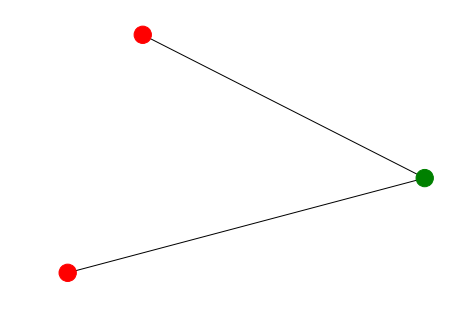

In [33]:
# Create the Subgraph 
subgraph_generator = max( networkx.connected_components( all_relations_nx ), key = len )

subgraph_graph = all_relations_nx.subgraph( subgraph_generator )

# Keep track of descriptive counters
num_awards = 0
num_faculty = 0
num_students = 0

# visualize the network       

# declare variables
subgraph_nodes = None
color_values = []
node_counter = -1
node = None
py2neo_node = None
node_properties_dict = None
node_id = 0
node_type = None

# set colors of nodes:
subgraph_nodes = subgraph_graph.nodes( data = True )
color_values = calculate_color_values_for_nodes( subgraph_nodes )

# loop over nodes to get counts of each type.

# use networkx graph.nodes() method to retrieve just list of nodes
subgraph_nodes = subgraph_graph.nodes( data = True )

# loop over nodes
node_counter = 0
for node in subgraph_nodes:
    
    # initialize variables
    node_id = 0
    node_type = None
    
    # get the node's properties (still a reference to py2neo.types.Node)
    py2neo_node = node[ 0 ]
    node_properties_dict = dict( py2neo_node )

    #print( "node[ 0 ] type = " + str( type( py2neo_node ) ) )
    
    # Is there an employee ID?
    if "employeeid" in node_properties_dict:

        # yes - it is ID, and also get position.
        node_id = node_properties_dict.get( "employeeid", None )
        node_type = node_properties_dict.get( "position", None )

    else:

        # no employee ID, so award.
        node_id = node_properties_dict.get( "award_num", None )
        node_type = "AWARD"
        
    #-- END check to see if employee ID. --#

    # What type?
    if node_type == "FACULTY":

        # FACULTY = green
        num_faculty += 1

    elif node_type == "STUDENT":

        # STUDENT = yellow
        num_students += 1

    else:

        # other = AWARD = red
        num_awards += 1
        
    #-- END check to see what type based on position --#
    
#-- END loop over nodes to get type counts --#
        
# draw the graph
networkx.draw( subgraph_graph, node_color = color_values )

# retrieve person data
person_data = list(networkx.get_node_attributes( subgraph_graph, 'position' ).values())

print( 'Number of Awards: ' + str( num_awards ) )
print( 'Number of Students: ' + str( num_students ) )
print( 'Number of Faculty: ' + str( num_faculty ) )

In [34]:
print( "_________________DEGREE CENTRALITY ________________" )
calculate_degree_centrality( subgraph_graph )
print( "_________________Betweenness ________________" )
calculate_betweenness( subgraph_graph )
print( "_________________Cliques ________________" )
find_cliques( subgraph_graph )
print( "_________________Diameter ________________" )
find_diameter( subgraph_graph )
print( "______________________________________________" )

_________________DEGREE CENTRALITY ________________
Highest degree Centrality:(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}) - 1.0
Highest degree Centrality:(a43fe2c:Award {award_num:"aw1468"}) - 0.5
Highest degree Centrality:(f6b7edd:Award {award_num:"aw1257"}) - 0.5
_________________Betweenness ________________
Highest Betweeness:(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}) - 1.0
Highest Betweeness:(a43fe2c:Award {award_num:"aw1468"}) - 0.0
Highest Betweeness:(f6b7edd:Award {award_num:"aw1257"}) - 0.0
_________________Cliques ________________
Number of cliques: 2
Size of cliques:[2, 2]
_________________Diameter ________________
Diameter: 2
______________________________________________


### Plotting Network Metrics

- back to [Table of Contents](#Table-of-Contents)

Betweeness and Centrality are both measures on how connnected a node is to its surounding nodes. However, they measure connectiveness in slightly different ways. A Node with high Degree centrality does not nessasarily mean the node also has a high level a Betwennness Centrality.

   A node with high betweenness but low degree might indicated that a node's few connections are critical to the shape of the graph

   A node with high degree but low betweenness might indicate that a node's connections are redundent and connections can bypass that node
    
    
### Exercise - degree vs. betweeness centrality

- back to [Table of Contents](#Table-of-Contents)

Run the Cell below to create a scatterplot of betweeness vs centrality of our subgraph

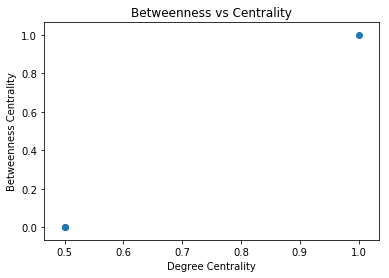

In [35]:
dc_data = list( networkx.degree_centrality( subgraph_graph ).values() )
bw_data = list( networkx.betweenness_centrality( subgraph_graph ).values() )

import numpy as np
import matplotlib.pyplot as plt

x = dc_data
y = bw_data

plt.scatter(x, y)

#title
plt.title("Betweenness vs Centrality")

#labels
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.show()

## Part 4 - Analysing Graphs

- back to [Table of Contents](#Table-of-Contents)

### Exercise - function that plots centrality metrics

- back to [Table of Contents](#Table-of-Contents)

1) Write a function that plots histgrams of the Degree of Centrality and Betweenness for a given graph.  The function should accept a networkx graph as an input parameter and return nothing.
 
2) Use the find_cliques() function to find the number of cliques in the graph 
 
3) Based of the graph you created above, the number of cliques, and the histograms of Centrality and Betweenness, how would you discribe the community this graph represents? 
 
Hint: Use networkx documentation to find a function that allows you to collect the attributes of a node 

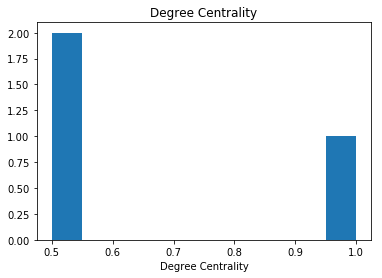

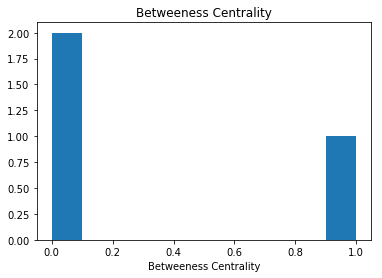

In [36]:
# Your soultion should Look somthing Like this 

def graph_data(graph):
    """
    Creates histograms of the the Degree of Centrality and the Betweenness Centrality 
    
    Parameters
    ----------
    graph - A Networkx object Graph. Graph nodes must have degree_centrality and betweenness attributes
    
    """
    # Create an empty list to hold all of our degree_centrality items  
    cen_list = []
    # Use the built in function get_node_attributes to collect the degree_centrality for each node
    for item in networkx.get_node_attributes(graph, 'degree_centrality'):
        cen_list.append(networkx.get_node_attributes(graph, 'degree_centrality')[item])
    
    # Pass the cen_list to a plt object and plot as a histogram 
    plt.figure(1)
    #title
    plt.title("Degree Centrality")

    #labels
    plt.xlabel("Degree Centrality")
    
    plt.hist(cen_list)
    
    # Create an empty list to hold all of our eigen_cent items 
    bw_list = []
    # Use the built in function get_node_attributes to collect the eigen_cent for each node
    for item in networkx.get_node_attributes(graph, 'betweenness'):
        bw_list.append(networkx.get_node_attributes(graph, 'betweenness')[item])
    
    # Pass the eig_list to a plt object and plot as a histogram 
    plt.figure(2)
    #title
    plt.title("Betweeness Centrality")

    #labels
    plt.xlabel("Betweeness Centrality")
    plt.hist(bw_list)

    
# Call the function graph_data() on our Networkx graph 
graph_data( subgraph_graph )



In [37]:
# Call the fucntion find_cliques() on our Networkx graph 
find_cliques( subgraph_graph )

Number of cliques: 2
Size of cliques:[2, 2]


[[(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}),
  (a43fe2c:Award {award_num:"aw1468"})],
 [(a21743e:Employee {employeeid:"90024517",position:"FACULTY"}),
  (f6b7edd:Award {award_num:"aw1257"})]]